### imports

In [1]:

import random
import time
import json
from datetime import datetime

import psycopg2
import numpy as np
from scipy.interpolate import LinearNDInterpolator
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline  

In [2]:
TERMINAL_COLORS = [
"\u001b[31m", "\u001b[32m", "\u001b[33m", "\u001b[34m", "\u001b[35m", "\u001b[36m", "\u001b[37m", "\u001b[31;1m", "\u001b[32;1m", "\u001b[33;1m", "\u001b[34;1m", "\u001b[35;1m",
]

TERMINAL_COLOR_RESET = "\u001b[0m"


# Tunescan

#### helper functions

In [ ]:
class TuneScan(dict):
    def __init__(self, timePoints, qx_min, qx_max, qy_min, qy_max, direction, numSweeps):
        self["timePoints"] = timePoints
        self["qx_min"] = qx_min
        self["qx_max"] = qx_max
        self["qy_min"] = qy_min
        self["qy_max"] = qy_max
        self["direction"] = direction
        self["numSweeps"] = numSweeps

        self["all_tunePoints"] = get_tunePoints_tuneScan(qx_min, qx_max, qy_min, qy_max, direction, numSweeps)

        return

    def run(self, shotCount):
        self["startTime"] = int(time.time() * 1e9)
        self["stopTime"] = None
        
        tuneScan_results = dict()
        for tune_idx, tunePoints in enumerate(tuneScan["all_tunePoints"]):
            # send to hardware
            print("perform trim")
            set_tunes(timePoints, tunePoints)
        
            # listen to DCCT
            client = SimpleClient(provider=RdaProvider())
            subscription = client.subscribe(
                PROPERTY_NAME,
                context=[
                    TimingSelector(FAIR_SELECTOR),
                    DATA_FILTER 
                ],
            )
        
            intensities = list()
            print("subscribing")
            for iteration, response in enumerate(subscription):
                if iteration == 0:
                    # old, potentially fake data
                    continue
                
                ts = response.value["acquisitionStamp"] / 1e9
                ts_datetime = datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')
        
                intensities.append(response.value["intensity"].tolist())
                
                print(TERMINAL_COLORS[1] + "DCCT" + 
                      " received S={}:P={}".format(response.value["sequenceIndex"], response.value["processIndex"]) +
                      "    " + ts_datetime +
                      TERMINAL_COLOR_RESET)
        
                if iteration == shotCount:
                    tuneScan_results[str(tune_idx)] = intensities
                    break

        self["tuneScan_results"] = tuneScan_results
        self["stopTime"] = int(time.time() * 1e9)

        return

### fetch from DB

In [3]:
DBNAME = "bpm_fesa_dump"
HOST = "pgsql.gsi.de"
PORT = "8646"
USER = "bpm_fesa_dump_slave"
PASSWORD = "kuwLMKTcAap6mKTP"

In [31]:
try:
    dbcon = psycopg2.connect("dbname="+DBNAME + " user=" + USER + " host=" + HOST + " port=" + PORT + " password=" + PASSWORD)
except Exception as e:
    print("Unable to connect to database")
    print(e)

crsr = dbcon.cursor()

In [46]:
readStatement = """
SELECT
    scanCompleted, direction, tuneScan
FROM
    bpm_fesa_dump.tunescan
;
"""

In [47]:
crsr.execute(readStatement)

data = crsr.fetchall()

In [70]:
for i, scan in enumerate(data):
    ts = scan[0] / 1e9
    ts_datetime = datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')
    
    print(i, scan[1], ts_datetime)

0 verticallyDownwards 2023-11-08 09:31:31
1 verticallyDownwards 2023-11-09 00:44:14
2 verticallyDownwards 2023-11-09 00:49:39
3 horizontallyUpwards 2023-11-09 01:02:32
4 horizontallyDownwards 2023-11-09 01:59:18
5 horizontallyDownwards 2023-11-09 02:08:52
6 verticallyUpwards 2023-11-09 02:17:10
7 verticallyUpwards 2023-11-09 02:35:26


In [240]:
tuneScan = data[7][2]

print(tuneScan["direction"], tuneScan["numSweeps"])

verticallyUpwards 25


# plot result

In [241]:
def convolutional_filter(signal):
    kernel = np.ones(9)  # make this uneven
    kernel /= kernel.sum()
    
    sig_padded = np.pad(signal, (kernel.shape[0] - 1)//2, mode="edge")
    
    return np.convolve(sig_padded, kernel, mode="valid")

In [242]:
def crop_signal(timePoints, signal):
    time_recording = np.linspace(0, timePoints[3] - timePoints[0], len(signal))

    time_scan = np.linspace(timePoints[1], timePoints[2], round(
        (timePoints[2] - timePoints[1]) / (timePoints[3] - timePoints[0]) * len(signal)
    ),)

    interp = np.interp(time_scan, time_recording, signal)

    return time_scan, interp

In [243]:
all_shots = list()
def interpolate_tuneScan_results(tuneScan):
    timePoints, tuneScan_results = tuneScan["timePoints"], tuneScan["tuneScan_results"]
    
    samples, labels = list(), list()
    for idx, tunePoints in enumerate(np.array(tuneScan["all_tunePoints"])):
        shots = [crop_signal(timePoints, s)[1] for s in tuneScan_results[str(idx)]]
    
        for i in range(len(shots)):
            # normalize intensity
            shots[i] = shots[i] / shots[i][0]
    
            # differentiate
#             shots[i] = np.diff(shots[i])
    
        shots = convolutional_filter(np.array(shots).mean(axis=0))
        shots = np.abs(np.diff(shots))
        
        all_shots.append(shots)
        
        qx_range = np.linspace(tunePoints[0][1], tunePoints[0][2], len(shots))
        qy_range = np.linspace(tunePoints[1][1], tunePoints[1][2], len(shots))
    
        for i in range(shots.shape[0]):
            samples.append((qx_range[i], qy_range[i]),)
            labels.append(shots[i])

    return LinearNDInterpolator(samples, labels)

In [244]:
interp = interpolate_tuneScan_results(tuneScan)

In [245]:
qx_range = np.linspace(tuneScan["qx_min"], tuneScan["qx_max"], 33)
qy_range = np.linspace(tuneScan["qy_min"], tuneScan["qy_max"], 33)
qx_range, qy_range = np.meshgrid(qx_range, qy_range)

result_scanInterpolated = interp(qx_range, qy_range)

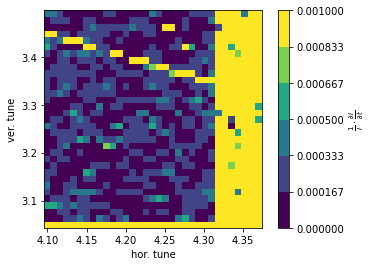

In [246]:
fig, ax = plt.subplots()

norm = mpl.colors.Normalize(vmin=0, vmax=0.001)

cmap = plt.get_cmap("plasma")
norm = mpl.colors.BoundaryNorm(np.linspace(0, 1e-3, 7), ncolors=cmap.N, clip=True)

pcm = ax.pcolormesh(qx_range, qy_range, result_scanInterpolated,
                    shading="auto", norm=norm)

cbar = fig.colorbar(pcm)

# make nice
ax.set_box_aspect(1)

ax.set_xlabel("hor. tune")
ax.set_ylabel("ver. tune")
cbar.set_label(r"$\frac{1}{I} \cdot \frac{\partial I}{\partial t}$")

#### plot imshow

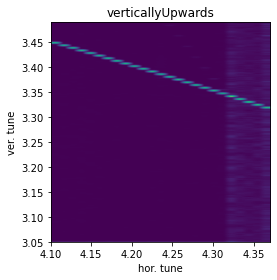

In [266]:
extent = [tuneScan["qx_min"], tuneScan["qx_max"], tuneScan["qy_min"], tuneScan["qy_max"]]

fig, ax = plt.subplots()

ax.imshow(np.stack(all_shots).T, extent=extent, aspect="auto", origin="lower")

ax.set_box_aspect(1)

# make nice
ax.set_title(tuneScan["direction"])
ax.set_xlabel("hor. tune")
ax.set_ylabel("ver. tune")

fig.tight_layout()
fig.savefig("/dev/shm/Tunescan.pdf", bbox_inches=None, pad_inches=1e-2)

# debug

In [165]:
timePoints = tuneScan["timePoints"]
results = tuneScan["tuneScan_results"]

results.keys()

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

In [166]:
timePoints

[0, 250000.0, 1950000.0, 2200000]

In [167]:
dcct = np.array(results["5"])
dcct.shape

(2, 2200)

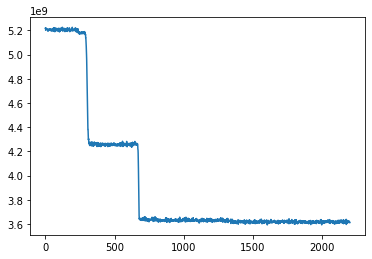

In [168]:
plt.plot(dcct[1])

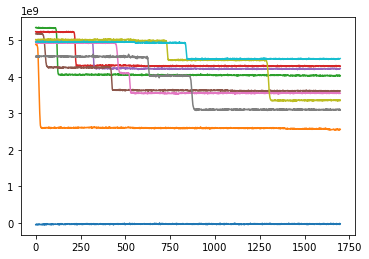

In [169]:
for i in range(len(results)):
    dcct = np.array(results[str(i)])
    
    time_scan, cs = crop_signal(timePoints, dcct[1])
    plt.plot(cs)
    

#### shots

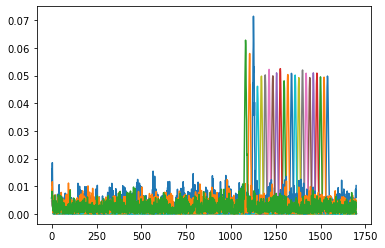

In [250]:
for i in range(len(all_shots[1:-1])):
    plt.plot(all_shots[i])